In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [78]:
class CNN(nn.Module):
  def __init__(self, num_classes):
    super(CNN, self).__init__()

    #change parameters based on image sizes, as of now 3x64x64 --> 16x32x32
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    #change parameters based on image sizes, as of now 16x64x64 --> 32x16x16
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    #self.dropout = nn.Dropout(p = 0.5)
    self.fc = nn.Linear(32*16*16, num_classes) #change to 32x32x32 if resized image to 128

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    #x = self.pool(F.relu(self.conv3(x)))
    x = x.view(x.size(0), -1)
    #x = self.dropout(x)
    x = self.fc(x)
    return x

In [79]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resizing to fit CNN input
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (change if using RGB)
])
dataset = datasets.ImageFolder('~/Desktop/UCLA/Junior/MATH156/reduced_dataset', transform = transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing to fit CNN input
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (change if using RGB)
])
dataset = datasets.ImageFolder('~/Desktop/UCLA/Junior/MATH156/reduced_dataset', transform = transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=5).to(device)  # 5 classes: baroque, etc.

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.5)
epoch_losses = []

In [84]:
for epoch in range(150):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")


Epoch 1: Loss = 1.5690
Epoch 2: Loss = 1.3896
Epoch 3: Loss = 1.3596
Epoch 4: Loss = 1.3386
Epoch 5: Loss = 1.3219
Epoch 6: Loss = 1.2748
Epoch 7: Loss = 1.2441
Epoch 8: Loss = 1.2302
Epoch 9: Loss = 1.1982
Epoch 10: Loss = 1.1871
Epoch 11: Loss = 1.1604
Epoch 12: Loss = 1.1670
Epoch 13: Loss = 1.1784
Epoch 14: Loss = 1.1339
Epoch 15: Loss = 1.1119
Epoch 16: Loss = 1.0938
Epoch 17: Loss = 1.0935
Epoch 18: Loss = 1.0671
Epoch 19: Loss = 1.0690
Epoch 20: Loss = 1.0470
Epoch 21: Loss = 1.0435
Epoch 22: Loss = 1.0432
Epoch 23: Loss = 1.0163
Epoch 24: Loss = 1.0305
Epoch 25: Loss = 1.0062
Epoch 26: Loss = 0.9953
Epoch 27: Loss = 0.9574
Epoch 28: Loss = 0.9653
Epoch 29: Loss = 0.9534
Epoch 30: Loss = 0.9153
Epoch 31: Loss = 0.9312
Epoch 32: Loss = 0.9124
Epoch 33: Loss = 0.8969
Epoch 34: Loss = 0.9146
Epoch 35: Loss = 0.8813
Epoch 36: Loss = 0.8386
Epoch 37: Loss = 0.8763
Epoch 38: Loss = 0.8480
Epoch 39: Loss = 0.8082
Epoch 40: Loss = 0.8326
Epoch 41: Loss = 0.8113
Epoch 42: Loss = 0.8098
E

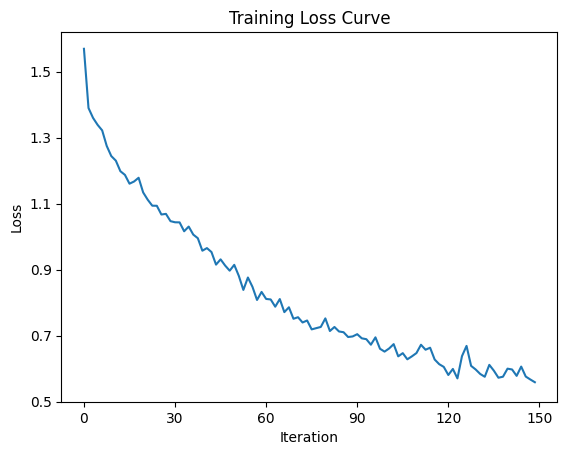

In [89]:
plt.plot(epoch_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=dataset.classes))